In [1]:
# reference : https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6

In [74]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
# read in all teh words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [76]:
# build vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [77]:
import random
random.seed(42)
random.shuffle(words)

In [78]:
#build dataset
block_size = 3 # context length : how any characters do we take to predict the next one?

def build_dataset(words):
    X,Y = [] , []
    for w in words :
        context = [0] * block_size
        for ch in w + '.' :
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = (int)(0.8*len(words))
n2 = (int)(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])   # 80% to training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% to validation
Xtest, Ytest = build_dataset(words[n2:]) # 10% to test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [14]:
# neural network setup

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters ( trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers ( trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize the unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        

In [15]:
torch.manual_seed(42); # for reproducability

In [16]:
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 200 # the number of neurons in hidden layer of MLP

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # lst layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [17]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1) # concatinate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update ; simple SGD
    lr = 0.1 if i<150000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
            

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


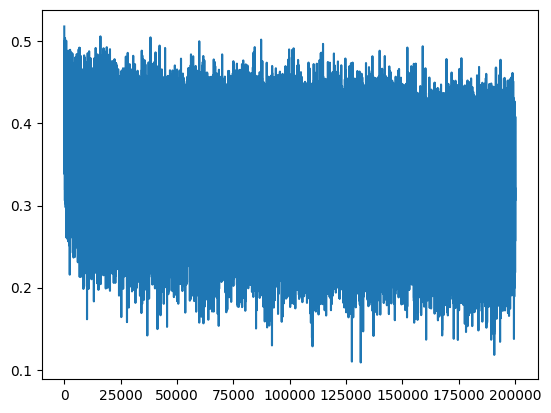

In [18]:
plt.plot(lossi)

In [19]:
#put layer into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [20]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest)
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1) # concat into (N, blocksize * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


In [22]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0],-1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim = 1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special character '.' , break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

esreezeal.
wyla.
bord.
ser.
apgbe.
saan.
krison.
jevellrah.
rid.
jayden.
layx.
syrias.
cir.
perhan.
yiah.
raelyn.
jacilianan.
calmarian.
giah.
hera.


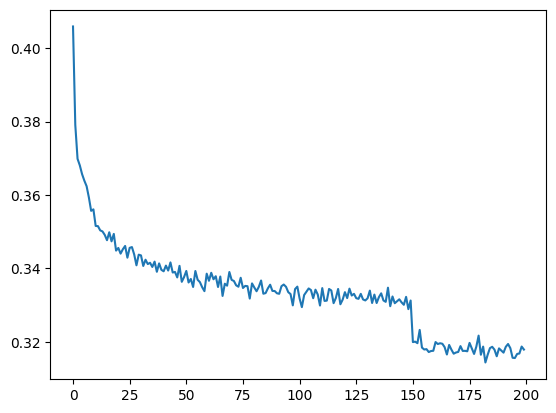

In [23]:
# we can imrpove the plot of lossi by averaging the row entries that way it looks nicer and easy to read
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [27]:
# we can further write clean code of forward pass and make it look simple. For this we create modules for embedding operation and flattening operation

# in neural network setup

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters ( trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers ( trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize the unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return []

In [28]:
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 200 # the number of neurons in hidden layer of MLP

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # lst layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update ; simple SGD
    lr = 0.1 if i<150000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break       

      0/ 200000: 3.2956


In [105]:
# lets further make our code similar to pytorch torch.nn
# we now add a module sequential which takes list of layers and runs them in sequentially

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters ( trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers ( trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize the unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]


class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return []

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [106]:
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 200 # the number of neurons in hidden layer of MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # lst layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [107]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update ; simple SGD
    lr = 0.1 if i<150000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
   

      0/ 200000: 3.5533
  10000/ 200000: 2.1134
  20000/ 200000: 2.0718
  30000/ 200000: 2.0075
  40000/ 200000: 2.1372
  50000/ 200000: 2.6414
  60000/ 200000: 1.7532
  70000/ 200000: 1.7637
  80000/ 200000: 2.6016
  90000/ 200000: 2.2487
 100000/ 200000: 2.1662
 110000/ 200000: 1.9608
 120000/ 200000: 2.4670
 130000/ 200000: 2.2822
 140000/ 200000: 2.0665
 150000/ 200000: 1.8801
 160000/ 200000: 2.3524
 170000/ 200000: 2.0860
 180000/ 200000: 2.0147
 190000/ 200000: 1.7658


In [109]:
#put layers in eval mode
for layer in model.layers:
    layer.training = False

In [110]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9216110706329346
val 2.0334458351135254


In [111]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        
        probs = F.softmax(logits, dim = 1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special character '.' , break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

rykell.
vanetu.
zelle.
oribelli.
shail.
jazia.
jamaeh.
lounyne.
roha.
emeya.
beani.
jorlen.
dayshawn.
sanav.
jaleen.
jaidon.
suriah.
niylend.
olawa.
maya.


In [116]:
# We add multiple layers to the neural network where the first layer takes characters and builds bigrams
# second layer takes bigrams and builds 4 len words
# and the next layer takes 4 len words to build 8 len words.


In [142]:
# We are changing the blocksize

#build dataset
block_size = 8 # context length : how any characters do we take to predict the next one?

def build_dataset(words):
    X,Y = [] , []
    for w in words :
        context = [0] * block_size
        for ch in w + '.' :
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = (int)(0.8*len(words))
n2 = (int)(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])   # 80% to training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% to validation
Xtest, Ytest = build_dataset(words[n2:]) # 10% to test

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [143]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [155]:
# lets further make our code similar to pytorch torch.nn
# we now add a module sequential which takes list of layers and runs them in sequentially

# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:  # modified batch normalization so it accepts 2D or 3D array
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [145]:
torch.manual_seed(42);

In [138]:
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 200 # the number of neurons in hidden layer of MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # lst layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [139]:
# lets run the model and see the output sahpe after each layer
ix = torch.randint(0,Xtr.shape[0], (4,)) # lets look at a batch of 4 examples
Xb, Yb = Xtr[ix] , Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [140]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [147]:
# Now we try to add layers like we explained 
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 200 # the number of neurons in hidden layer of MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # lst layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [148]:
# lets run the model and see the output sahpe after each layer
ix = torch.randint(0,Xtr.shape[0], (4,)) # lets look at a batch of 4 examples
Xb, Yb = Xtr[ix] , Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  3, 25, 14,  3],
        [ 0,  0,  0,  0,  2, 18,  1,  4],
        [ 0,  0,  0,  0,  0,  0,  4, 15],
        [ 0,  0,  0, 14,  9, 15, 13,  9]])

In [149]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [150]:
# lets minimize the number of parameters just not to overload the execution
# we change the number of neurons in the hidden layers to 68 from 200

# Now we try to add layers like we explained 
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 68 # the number of neurons in hidden layer of MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
#parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # lst layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


22397


In [151]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update ; simple SGD
    lr = 0.1 if i<150000 else 0.01 # step learning decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3479
  10000/ 200000: 1.9803
  20000/ 200000: 2.0424
  30000/ 200000: 1.9121
  40000/ 200000: 2.3474
  50000/ 200000: 2.2584
  60000/ 200000: 2.4160
  70000/ 200000: 1.7192
  80000/ 200000: 2.0493
  90000/ 200000: 1.8298
 100000/ 200000: 1.9611
 110000/ 200000: 1.7984
 120000/ 200000: 1.7235
 130000/ 200000: 1.8516
 140000/ 200000: 1.9044
 150000/ 200000: 1.9262
 160000/ 200000: 1.8281
 170000/ 200000: 1.9434
 180000/ 200000: 2.0999
 190000/ 200000: 2.0585


In [152]:
#put layers in eval mode
for layer in model.layers:
    layer.training = False

In [153]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9117786884307861
val 2.017289638519287


In [154]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        
        probs = F.softmax(logits, dim = 1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special character '.' , break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

amir.
twenler.
talen.
mackem.
denyah.
morgyah.
kashtzi.
dio.
tollyson.
rinsly.
finnie.
ketro.
shaam.
deanna.
zericah.
meidel.
damerix.
skyan.
nase.
maanna.
